<h2>kaggleのデータセット「Kickstarter Projects」を使って分類問題を解く</h2>
「Kickstarter Projects」ではstateと呼ばれる列によってプロジェクトが成功したか失敗したか分けられる。<br>
stateには複数種類があり、中には現在でもプロジェクトを継続しているもの(live)、資金調達こそしたがプロジェクトを途中で撤退したもの(canceled)などがあり、一概に成功・失敗を決められないプロジェクトも存在する。<br>
そこで、stateがsuccessfulのデータ、failedのデータに絞って他の変数との相関を調べることからデータ分析を始める。<br>

In [1]:
#今回の分析に用いるライブラリをインポートする
import pandas as pd
import numpy as np
import re
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import datetime

In [2]:
#CSVファイルを読み込む
df = pd.read_csv("../1_data/ks-projects-201801.csv")
df.index.name="id"

実際にstateがsuccessfulのデータ、failedのデータに絞りこむ

In [4]:
#stateが「live」のデータを落としていることを明示するためにあえて記載
df = df[df['state'] != 'live']
df = df[(df['state'] == 'successful') | (df['state'] == 'failed')]

<h2>欠損値に関して</h2>
データ全体を見ると、分析に必要な値が必ずしも記載されているとは限らず、<br>
分析に支障が出るデータが存在する。<br>
欠損を表す値で補完するか、データ自体を分析対象から外すなど、何かしらのアプローチが必要となる。

In [6]:
#欠損値がある列を確認
df.isnull().sum()

ID                    0
name                  3
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         210
usd_pledged_real      0
usd_goal_real         0
dtype: int64

In [7]:
#欠損値がどのような列か参照する
df[df['name'].isnull()]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
id,,,,,,,,,,,,,,,
166851,1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,200000.0,2012-01-01 12:35:31,100.0,failed,1,US,100.00,100.00,200000.00
307234,634871725,NaN,Video Games,Games,GBP,2013-01-06,2000.0,2012-12-19 23:57:48,196.0,failed,12,GB,317.73,316.05,3224.97
338931,796533179,NaN,Painting,Art,USD,2011-12-05,35000.0,2011-11-06 23:55:55,220.0,failed,5,US,220.00,220.00,35000.00


In [4]:
#usd pledged列も欠損値がある為、実際に列を参照する
df[df['usd pledged'].isnull()]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
id,,,,,,,,,,,,,,,
169,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06 21:28:36,555.00,undefined,0,"N,0""",NaN,555.00,6500.00
328,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.0,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",NaN,3402.08,3211.53
632,1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.0,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",NaN,3576.00,3500.00
647,1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.0,2015-11-02 22:09:19,7007.80,undefined,0,"N,0""",NaN,7007.80,6000.00
749,1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.0,2016-02-23 03:09:49,3660.38,undefined,0,"N,0""",NaN,3660.38,3000.00
824,1004013077,Spencer Capier Instrumental Project 2015,Music,Music,CAD,2014-10-10,4000.0,2014-09-10 22:51:01,4760.00,undefined,0,"N,0""",NaN,4251.14,3572.39
844,1004126342,LUKAS LIGETI'S 50TH BIRTHDAY FESTIVAL: ORIGINA...,Music,Music,USD,2015-06-11,5000.0,2015-05-15 02:12:35,6370.00,undefined,0,"N,0""",NaN,6370.00,5000.00
864,1004255433,The Battle For Breukelen: A Neighborhood Epic,Film & Video,Film & Video,USD,2015-11-07,6000.0,2015-10-10 18:45:24,6695.00,undefined,0,"N,0""",NaN,6695.00,6000.00
870,1004298993,"""Tamboura Plays Violin"" - a collection of Pop ...",Music,Music,USD,2015-03-28,2750.0,2015-02-11 19:28:27,2926.00,undefined,0,"N,0""",NaN,2926.00,2750.00


usd pledgedは実際に集金できた金額を表示した列であり、機械学習の際にはリーケージを防ぐために削除する列だが、
欠損値になったからといってほかの列に際立った特徴は見られないため、いったん保留して、機械学習実施の際に削除する

<h2>goal,usd_goal_realのスケールを見る</h2>
goalがプロジェクト開始時に定めた目標金額を表しているが、<br>
こちらをUSドルの数値に変換したusd_goal_realという列が存在する。<br>
内容としてはほぼ変わらない考えだが、スケールの差を確認して、分析に影響が出るか確認する。

In [9]:
#分析用データフレームを別に用意する
df_anl = df.copy()

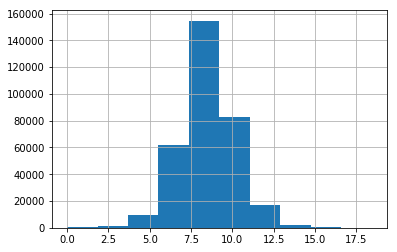

In [10]:
#スケールが大きいので対数変換してからヒストグラムを作成
df_anl['goal_log'] = df_anl['goal'].apply(lambda x: np.log(x+1))
df_anl['goal_log'].hist()

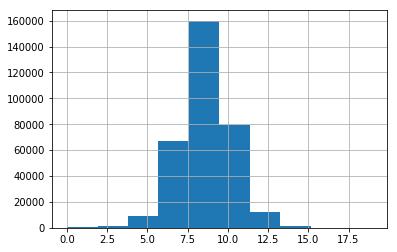

In [11]:
df_anl['usd_goal_real_log'] = df_anl['usd_goal_real'].apply(lambda x: np.log(x+1))
df_anl['usd_goal_real_log'].hist()

goal,usd_goal_realにスケールの差はほぼ見られず、説明変数としてはどちらか一方のみを利用するものとして検討する。

### main_categoryとcategoryの組み合わせ、また他の列の相関を見る
データ分析の際に説明変数として利用できそうな列はいくつか存在する。<br>
説明変数としてどのような特徴を持つか、また列同士の関係性はあるか、確認する。<br>
これらの列から、新たな特徴を持った列を
* deadline : プロジェクト開始時点で定めた納期
* launched : プロジェクト開始日
* main_category : どういったプロジェクトか、大まかな分類
* category : プロジェクトの詳細な分類

In [12]:
#deadline,launchedを日付に変換するための関数
def period_to_date(x_date, format_date):
    x_date_format = datetime.datetime.strptime(x_date, format_date)
    return x_date_format

In [13]:
#categoryとmain_categoryを組み合わせた列を作成
df_anl['category_merged'] = df_anl['category'] + ',' + df_anl['main_category']
df_anl['category_merged']

id
0                   Poetry,Publishing
1         Narrative Film,Film & Video
2         Narrative Film,Film & Video
3                         Music,Music
5                    Restaurants,Food
6                           Food,Food
7                         Drinks,Food
10              Nonfiction,Publishing
11                   Indie Rock,Music
12                      Crafts,Crafts
13                        Games,Games
14               Tabletop Games,Games
15                      Design,Design
16                 Comic Books,Comics
17               Art Books,Publishing
18                        Music,Music
19                          Food,Food
20                    Fashion,Fashion
21              Childrenswear,Fashion
22                    Theater,Theater
23                        Drinks,Food
24                      Comics,Comics
25                        Music,Music
26                         DIY,Crafts
27             Webseries,Film & Video
28                      Comics,Comics
29       

category,main_categoryの組み合わせで各データを表示。<br>
これによりどういったcategoryでプロジェクトが成功するか、失敗するか1列で比較が出来る

In [14]:
#deadline と　launched からプロジェクト納期への近さ(日数)を計算
df_anl['deadline_period'] = df_anl['deadline'].apply(lambda x : period_to_date(x, '%Y-%m-%d')) - df_anl['launched'].apply(lambda x : period_to_date(x, '%Y-%m-%d %H:%M:%S'))
df_anl['deadline_days'] = df_anl['deadline_period'].apply(lambda x : x.days)

#deadline_daysから1日あたりの目標金額を計算
df_anl['goal_per_days'] = df_anl['goal'] / df_anl['deadline_days']
df_anl['goal_per_days'] = df_anl['goal_per_days'].fillna(0)
df_anl['goal_per_days'] [df_anl['goal_per_days'] == np.inf]= 0

/home/takuya-06261_semantic/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
#pairplot用の変数を揃える
#ここでは更に、pledged(実際の収益),backers(結果として付いた支援者),deadline_days(納期の長さ)を指標として加える

df_anl['pledged_log'] = df_anl['pledged'].apply(lambda x: np.log(x+1))
df_anl['backers_log'] = df_anl['backers'].apply(lambda x: np.log(x+1))
df_anl['deadline_days_log'] = df_anl['backers'].apply(lambda x: np.log(x+1))

df_pairplot = df_anl.loc[:,['category_merged','goal_log', 'pledged_log', 'backers_log', 'deadline_days_log', 'state']]

In [ ]:
#納期の長さを階級区分
#短納期のプロジェクトが多数
df_anl['deadline_days_log'].hist()

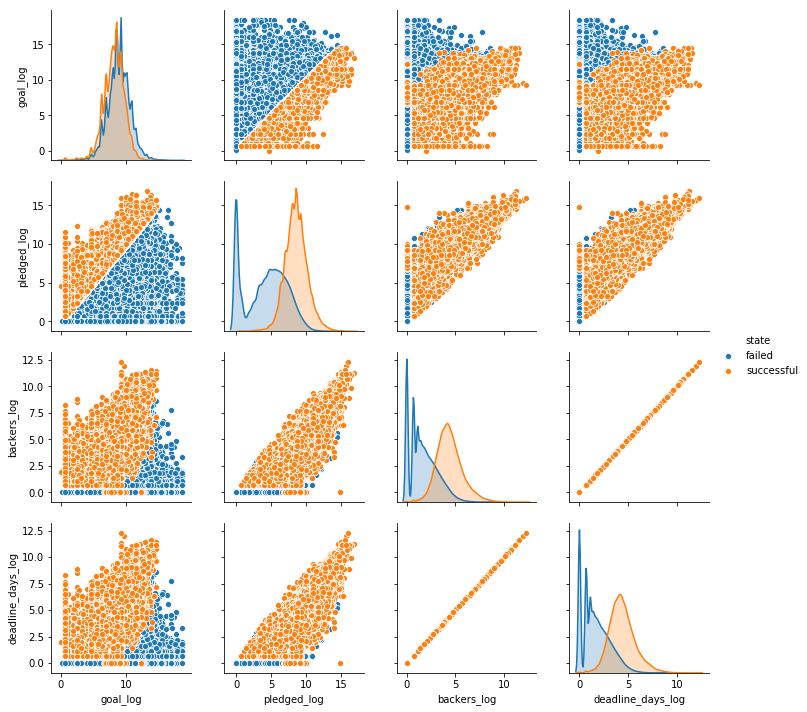

In [17]:
sns.pairplot(df_pairplot, hue='state')

相関係数を見る。下記の表で分かるように、goalとpleged以外に強い相関を持つ列は存在しない。<br>
goal(目標金額) + pledged以外の列を説明変数として機械学習モデルを構築する方法が考えられる。<br>
ただし、backersはリーケージにつながるため直接利用できず、<br>
PJ開始時点で分かる別の説明変数を導入する必要がある。<br>

In [18]:
#pairplotに使用した変数の相関を見る
df_pairplot.corr()

,goal_log,pledged_log,backers_log,deadline_days_log
goal_log,1.000000,0.146582,0.120068,0.120068
pledged_log,0.146582,1.000000,0.926765,0.926765
backers_log,0.120068,0.926765,1.000000,1.000000
deadline_days_log,0.120068,0.926765,1.000000,1.000000


In [19]:
#ブースティング系アルゴリズムの使用も考えて、目的変数stateを数値の形に変換
df_anl['state'].loc[df_anl['state'] == 'successful'] = 1
df_anl['state'].loc[df_anl['state'] == 'failed'] = 0

/home/takuya-06261_semantic/anaconda3/envs/my_env/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [20]:
#backers_invest(backers一人当たりの投資額)を見る
df_anl['backers_invest'] = df_anl['pledged'] / df_anl['backers']#0除算が発生するので対処
df_anl['backers_invest'] = df_anl['backers_invest'].fillna(0)
df_anl['backers_invest'] [df_anl['backers_invest'] == np.inf]= 0

/home/takuya-06261_semantic/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [22]:
#stateを1(成功)-0(失敗)で表現しているため、state列の値が大きいほど、相対的に成功率が高いと解釈できる
df_cat = df_anl.groupby(['category_merged']).mean()
df_cat.loc[:,['backers', 'backers_invest', 'goal_per_days','pledged','state']].sort_values('backers', ascending=False)

,backers,backers_invest,goal_per_days,pledged,state
category_merged,,,,,
"Camera Equipment,Technology",505.471429,257.847176,1224.639855,99050.680543,0.548571
"Tabletop Games,Games",499.565651,62.994169,470.917879,40064.113873,0.669789
"Chiptune,Music",470.606061,50.150464,216.946621,18328.975455,0.818182
"Wearables,Technology",455.315408,142.938081,1915.883900,72510.420434,0.401241
"Video Games,Games",451.030875,47.492340,1787.970342,21772.010695,0.255789
"Sound,Technology",421.916515,238.373711,1489.761313,79138.721960,0.497278
"Gaming Hardware,Games",408.721649,96.403374,2846.646364,57418.677354,0.340206
"Gadgets,Technology",366.219113,137.538750,1876.038891,39310.541326,0.356005
"Hardware,Technology",350.417657,167.828858,2664.101781,50083.038504,0.387159


ソートした結果を見ても、backerがついているから、backers_invest(一人当たりの投資額)が高いからと言って、
PJ成功率が高いとは限らない。しかし、backerがつかないPJはそもそも成功しないことが分かる。

In [23]:
#state(成功率の高さでソート)
df_cat.loc[:,['backers', 'backers_invest', 'goal_per_days','pledged','state']].sort_values('state', ascending=False)

,backers,backers_invest,goal_per_days,pledged,state
category_merged,,,,,
"Chiptune,Music",470.606061,50.150464,216.946621,18328.975455,0.818182
"Anthologies,Comics",306.958549,45.839331,337.443344,15710.205518,0.784974
"Residencies,Dance",40.411765,105.017442,533.849987,4136.818529,0.735294
"Dance,Dance",47.600992,74.829469,266.832810,3771.257570,0.695221
"Letterpress,Crafts",93.250000,55.332965,177.572484,5547.992222,0.694444
"Literary Spaces,Publishing",126.105263,112.623261,420.268261,11426.052632,0.684211
"Indie Rock,Music",64.605367,60.760494,190.637867,4152.468795,0.678927
"Classical Music,Music",56.097131,97.234391,301.930337,5033.646869,0.675000
"Tabletop Games,Games",499.565651,62.994169,470.917879,40064.113873,0.669789


main_categoryがMusicであっても、Gamesであっても、成功率が高い詳細カテゴリ(以下、category)と逆に低いものも存在する。<br>
説明変数として使うなら、categoryが△△かどうか、といったものは使えそうであることが分かる。

In [25]:
#全行参照するためCSV出力
df_state_cat.to_csv('../1_data/ks_projects_201801_sort_state.csv')

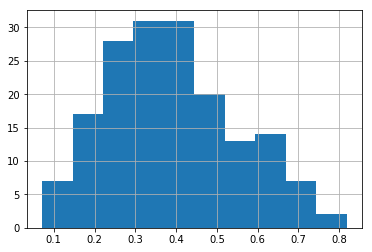

In [26]:
#先ほど出した成功率を階級区分化
#最頻値が30~40%の範囲内にある為、やはりPJの成功率は低い
df_state_cat['state'].hist()

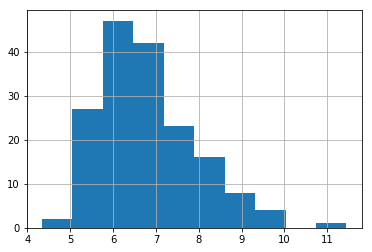

In [27]:
#1日あたりの目標金額を階級区分化
#対数変換した結果なので実際は400~1100ドルは稼げないと厳しそうに見える。
#backers_investは40以上で成功が見えるので、5～6日で後援者1人,1ヶ月時点で10人もつけばPJ成功が見えてくるか。
df_state_cat['goal_per_days_log'] = df_state_cat['goal_per_days'].apply(lambda x: np.log(x+1))

df_state_cat['goal_per_days_log'].hist()

In [28]:
#同様にして、currency,countryも検証
df_country = df_anl.groupby(['country']).mean()
df_country.loc[:,['backers', 'backers_invest','goal_per_days','pledged','state']].sort_values('state', ascending=False)

,backers,backers_invest,goal_per_days,pledged,state
country,,,,,
"N,0""",0.000000,0.000000,730.943120,15771.082952,0.500000
HK,154.352201,1054.189344,5871.901257,149658.499224,0.452830
US,122.744739,66.224161,1221.612128,10481.959690,0.418193
GB,92.760847,44.094262,982.443278,5239.418758,0.409690
SG,144.594714,105.424189,668.110386,16101.788128,0.392070
DK,76.523758,449.011543,4324.422720,51141.186652,0.388769
FR,130.843254,72.600578,2319.805965,11677.689607,0.360317
NZ,78.177394,85.744370,868.398574,8192.950000,0.351648
SE,105.524851,451.513887,8387.071338,69611.188443,0.337309


In [29]:
#同様にして、currency,countryも検証
df_currency = df_anl.groupby(['currency']).mean()
df_currency.loc[:,['backers', 'backers_invest','goal_per_days','pledged','state']].sort_values('state', ascending=False)

,backers,backers_invest,goal_per_days,pledged,state
currency,,,,,
HKD,154.352201,1054.189344,5871.901257,149658.499224,0.452830
USD,122.673865,66.185922,1221.439937,10487.961433,0.418258
GBP,92.691614,44.061351,981.790437,5236.731883,0.409859
SGD,144.594714,105.424189,668.110386,16101.788128,0.392070
DKK,76.276642,447.561560,4312.062076,51009.614467,0.389666
NZD,78.177394,85.744370,868.398574,8192.950000,0.351648
SEK,105.454967,451.214871,8382.316255,69578.532026,0.337086
CAD,99.481535,73.322377,1928.026724,8580.104313,0.334303
JPY,43.869565,10595.376013,52764.869962,418343.739130,0.304348


currency,countryは単独ではプロジェクト成功率との関連は弱いが、どちらか一つは説明変数の一つの候補とはなりそう。

<h2>プロジェクト名称を表す列、nameの特徴を調べる</h2>
ここまで扱ってきた列のみでなく、プロジェクト名称にも特徴量がある可能性がある。<br>


In [30]:
#nameの長さを取得
df_anl['name_length'] = df_anl['name'].apply(lambda x: len(str(x).replace(' ', ''))).fillna(0)

In [31]:
#nameの長さでソート
df_anl.loc[:,['name','name_length','backers','backers_invest','goal_per_days','pledged','state']].sort_values('name_length', ascending=False)

,name,name_length,backers,backers_invest,goal_per_days,pledged,state
id,,,,,,,
302357,Honduras. Photograph Coffee Farmers. Tell thei...,76,3,41.666667,100.000000,125.00,0
160830,Stimulate the fusion of comic/music/animation ...,76,2,55.000000,140.000000,110.00,0
330372,"Norcio to record ""Dear Christina"" @ Applehead ...",75,2,52.500000,83.333333,105.00,0
126858,"""Absolutely American"" open to Contributors/Spo...",75,0,0.000000,2247.191011,0.00,0
285792,"""Thunder-Sky"" Movie of outsider, autistic Nati...",75,2,57.500000,625.000000,115.00,0
337243,Corpus Christi:Playing with Redemption- A film...,75,128,82.718750,357.142857,10588.00,1
302387,LOOSE INTERPRETATIONS:full lengthish buffet of...,75,2,35.000000,26.666667,70.00,0
75008,Starve Andrew: 25-Days of Fasting and Investig...,75,3,63.333333,309.523810,190.00,0
34293,Hands That Feed: Haiti's food crisis and post-...,75,216,73.151296,394.736842,15800.68,1


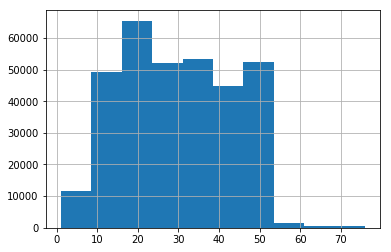

In [46]:
#name_lengthは1～76文字の範囲内であり、外れ値とおぼしき値はない
df_anl['name_length'].hist()

In [32]:
#分析結果をまとめてCSV出力
df_anl.sort_values('name_length', ascending=False).to_csv('../1_data/ks_projects_201801_analysis.csv')

名前の長さそのものよりは、名前の中にある特徴が存在して、backerがつきPJが成功する要因となる特徴がありそう。

In [33]:
#データフレームを成功したものと失敗したもので分割
df_succeed = df_anl[df_anl['state'] == 1]
df_failed = df_anl[df_anl['state'] == 0]

In [34]:
#成功したPJの件数
len(df_succeed)

133956

In [35]:
#失敗したPJの件数
len(df_failed)

197719

成功したプロジェクトと失敗したプロジェクトでデータフレームを分けているが、全てまとめて特徴を見たほうが良かった。<br>
(2019/10/19加筆)

In [36]:
#成功したPJに関して、nameに使われている英単語の個数を見る
import re
from collections import Counter

# 00 テキストの取得
target_text = []

df_succeed = df_succeed.astype(str)

# 英単語を小文字で統一
#df_succeed['name'] = df_succeed['name'].str.lower()

#英単語の表記ゆれが見つかったため小文字に統一
#df_succeed['name'] = df_succeed['name'].str.replace('the|The|"The|"the|THE','the')
#df_succeed['name'] = df_succeed['name'].str.replace('Debut|debut','debut')
#df_succeed['name'] = df_succeed['name'].str.replace('and|&','and')
#df_succeed['name'] = df_succeed['name'].str.replace('-|–','-')
#df_succeed['name'] = df_succeed['name'].str.replace('An|an','an')
#df_succeed['name'] = df_succeed['name'].str.replace('ON|on|On','on')
#df_succeed['name'] = df_succeed['name'].str.replace('OF|of|Of','of')


for id_words in df_succeed['name']:
    target_text += id_words
    

# 01 複数の区切り文字を指定するため re.split を使う
words = re.split(r'\s|\,|\.|\(|\)', ''.join(target_text))

# 02 集計する
counter = Counter(words)

# 04 表示する
# Counter#most_common を使って出現率の上位100位を表示する(1位は空文字のため省略)
for word, count in zip(counter.most_common(),range(101)):
    if len(word) > 0:
        print("%s,%d" % (word, count))

('', 25646),0
('-', 21799),1
('the', 13060),2
('of', 12814),3
('The', 11655),4
('A', 10991),5
('and', 8467),6
('a', 8342),7
('&', 7249),8
('for', 6890),9
('to', 5899),10
('in', 5396),11
('by', 4321),12
('New', 3674),13
('with', 2320),14
('Album', 2009),15
('Debut', 1975),16
('on', 1958),17
('Art', 1935),18
('Short', 1931),19
('new', 1846),20
('First', 1725),21
('Music', 1678),22
('at', 1677),23
('|', 1647),24
('from', 1566),25
('Book', 1523),26
('Film', 1520),27
('An', 1519),28
('Your', 1484),29
('is', 1328),30
('your', 1297),31
('an', 1289),32
('album', 1124),33
(':', 1090),34
('THE', 1063),35
('Game', 1025),36
('For', 1023),37
('To', 952),38
('film', 951),39
('2', 932),40
('short', 901),41
('Playing', 899),42
('In', 877),43
('EP', 867),44
('+', 848),45
('Card', 806),46
('You', 802),47
('first', 798),48
('/', 793),49
('about', 790),50
('Project', 787),51
('CD', 770),52
('My', 750),53
('I', 702),54
('Of', 685),55
('Dance', 640),56
('debut', 636),57
('Volume', 611),58
('Studio', 610),59

In [37]:
#失敗したPJに使われている英単語を見る
#テキストの取得
target_text = []

df_failed = df_failed.astype(str)

#英単語を小文字で統一
#df_failed['name'] = df_failed['name'].str.lower()

for id_words in df_failed['name']:
    target_text += id_words

#複数の区切り文字を指定するため re.split を使う
words = re.split(r'\s|\,|\.|\(|\)', ''.join(target_text))

#集計する
counter = Counter(words)

#表示する
# Counter#most_common を使って出現頻度の上位100位を表示する
for word, count in zip(counter.most_common(),range(100)):
    if len(word) > 0:
        print("%s,%d" % (word, count))
# => csv 形式の単語出現回数

('', 38653),0
('-', 25253),1
('the', 17105),2
('of', 16830),3
('The', 14176),4
('and', 12755),5
('A', 11374),6
('for', 10472),7
('a', 10460),8
('to', 8981),9
('&', 8473),10
('in', 6848),11
('by', 3538),12
('with', 3497),13
('New', 2729),14
('on', 2716),15
('your', 2597),16
('Art', 2252),17
('Music', 2213),18
('Your', 2080),19
('Book', 1845),20
('For', 1822),21
('is', 1673),22
('from', 1606),23
('an', 1555),24
('First', 1548),25
('To', 1533),26
('new', 1520),27
('An', 1511),28
('Of', 1494),29
('Film', 1450),30
('In', 1382),31
('|', 1380),32
('Album', 1378),33
('My', 1370),34
('THE', 1325),35
(':', 1322),36
('at', 1321),37
('Game', 1311),38
('my', 1243),39
('Short', 1133),40
('I', 1123),41
('Food', 1064),42
('Life', 1061),43
('/', 1029),44
('World', 1018),45
('Debut', 997),46
('Project', 991),47
('Video', 960),48
('You', 954),49
('you', 952),50
('first', 949),51
('book', 948),52
('With', 899),53
('Love', 842),54
('about', 832),55
('that', 821),56
('film', 809),57
('2', 809),58
('album', 

単語だけで見ると、上位30位以下は全体の件数に対して1%も現れておらず、今一つ傾向が見えてこない。<br>
この単語が含まれているから成功する／失敗するといった過剰な傾向はなさそう。<br>
他にart,music,booksなど芸術分野の単語が頻出。

<h2>プロジェクト名nameのベクトル化</h2>
nameに登場する単語をベクトル化して類似したプロジェクトがないか、特徴を見る。

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# ベクトル化する文字列
succeed_name = np.array(df_succeed['name'])

vec_tfidf = TfidfVectorizer()

# ベクトル化
X = vec_tfidf.fit_transform(succeed_name)

In [39]:
# memory_errorにより全件では単語ベクトルを生成できず
pd.DataFrame(X.toarray(), columns=vec_tfidf.get_feature_names())

MemoryError: 

In [40]:
#データフレームの一部を抽出
df_succeed_part = df_succeed[0:100]

# ベクトル化する文字列
succeed_name = np.array(df_succeed_part['name'])

vec_tfidf = TfidfVectorizer()

# ベクトル化
tfidf_model = vec_tfidf.fit(succeed_name)
X = tfidf_model.transform(succeed_name)

In [41]:
#データフレームの一部を抽出
df_failed_part = df_failed[0:100]

# ベクトル化する文字列
failed_name = np.array(df_failed_part['name'])

vec_tfidf_fail = TfidfVectorizer()

# ベクトル化
tfidf_model_fail = vec_tfidf_fail.fit(failed_name)
X_fail = tfidf_model_fail.transform(failed_name)

In [42]:
#ベクトル化した単語のコサイン類似度を計算
from sklearn.metrics.pairwise import cosine_similarity
cs = cosine_similarity(X.toarray(),X.toarray())

In [43]:
#コサイン類似度から成功したPJに似通った文書がないかどうか見る
for i, cs_item in enumerate(cs):
    print("[" + succeed_name[i] + "]")
    cs_dic = {}
    for j, cs in enumerate(cs_item):
        if round(cs - 1.0, 5) != 0 and round(cs, 5) != 0: #同じ文書同士,類似度0は省く
            cs_dic[succeed_name[j]] = cs
    for k, v in sorted(cs_dic.items(), key=lambda x:x[1], reverse=True):
        print("\t" + k + " : " + str(v))

[Monarch Espresso Bar]
[Support Solar Roasted Coffee & Green Energy!  SolarCoffee.co]
	Water Purification System Using Solar Evacuated Tube : 0.11495302790205177
[Lisa Lim New CD!]
	Camille Peruto - NEW ALBUM : 0.18405694991851726
	My Future Just Passed - Debut CD - Jazz Trio : 0.16919526236121318
	Help Scott Reynolds Make a New Record! : 0.14423412269017435
	Chris Eger Band - New Nashville Record! : 0.14278198568472658
	VLC for the new Windows 8 User Experience ("Metro") : 0.12666429822187086
[Tombstone: Old West tabletop game and miniatures in 32mm.]
	DAYTRADER - A Financial Board Game : 0.15186929060540863
	Star and the Snowman : 0.1326349444739698
	The Spider and the Fly : 0.11524860660110871
	Zen in America: a film on Zen Buddhism in North America : 0.10662382798295286
	A Teacher's Travels in China : 0.10418982037928728
	Four Short Stories and Ten Love Poems : 0.08631653683464781
	I'LL SEE YOU IN MY DREAMS - narrative feature film : 0.07064565282171023
	Mothers Into Living Fit Yog

In [44]:
cs_fail = cosine_similarity(X_fail.toarray(),X_fail.toarray())

In [45]:
#コサイン類似度から失敗したPJに似通った文書がないかどうか見る
for i, cs_item in enumerate(cs_fail):
    print("[" + failed_name[i] + "]")
    cs_dic = {}
    for j, cs in enumerate(cs_item):
        if round(cs - 1.0, 5) != 0 and round(cs, 5) != 0: #同じ文書同士,類似度0は省く
            cs_dic[failed_name[j]] = cs
    for k, v in sorted(cs_dic.items(), key=lambda x:x[1], reverse=True):
        print("\t" + k + " : " + str(v))

[The Songs of Adelaide & Abullah]
	The Gentle Art Of Tutelage : 0.19865370808610766
	The Beard : 0.1536034962230304
	The Fanalyzers: Views from the Stands : 0.15311574542971187
	The Onrust Project and Two Row Treaty of 1613 : 0.140503973510876
	Of Jesus and Madmen : 0.12505506121599422
	The Cottage Market : 0.10869624904186193
	The Seven Rays : 0.10869624904186193
	A photobook of life in Japan : 0.10532032284759082
	Teachers In The Sky : 0.09762798363892664
	Rack and Ruin, Out of Orbit 3 : 0.09557555282795274
	"JurassicJurassix" by The Guilt : 0.09467052801973466
	H2O The Underwater Portraits : 0.09086028178529515
	Following the Call - A Novel : 0.09086028178529515
	Jane Brown... a story of courage, survival and love : 0.08327160062121608
	WE ARE ONE: STREET MUSIC OF NEW ORLEANS : 0.0821306858492709
	The Legendary YD 2016 Tour : 0.07965131726046845
	iRNinja - Control your TV with a simple press of a button : 0.07608593676340786
	Legacy of Svarog | a Unique 3D Action RPG and Adventure G

ここまでの分析結果から、name列に関しては、失敗しそうなPJには際立った単語はなく、成功したPJに投資者の目を引く単語が入っているか注目。<br>
1st,quickなどの早い時制を表す単語が含まれているか、theatre,movieなど映画に関連する単語が含まれているかといった観点で<br>
学習モデルを作っていくのが良さそうに見えたが、分析方法としては疑問が残る方法となった。